In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 添加这行
import re

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [3]:
path = './results_long_term_forecasting'
datasets = sorted(os.listdir(os.path.join(path, f'resultsGym_non_transformer')))
datasets = [_ for _ in datasets if _ != 'ili']
result_dict, runtime_dict = {}, {}
for dataset in datasets:
    result_dict[dataset], runtime_dict[dataset] = {}, {}
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        file_list = os.listdir(os.path.join(path, f'resultsGym_non_transformer', dataset)) +\
                    os.listdir(os.path.join(path, f'resultsGym_transformer', dataset))
        file_list = [_ for _ in file_list if f'pl{pred_len}' in _]
        result_dict[dataset][pred_len], runtime_dict[dataset][pred_len] = {}, {}
        for file in file_list:
            try:
                result = np.load(os.path.join(path, f'resultsGym_non_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
            except:
                try:
                    result = np.load(os.path.join(path, f'resultsGym_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
                except:
                    continue
            result_dict[dataset][pred_len][file] = result[1]

        # metrics = result_dict[dataset][pred_len].values()
        # metrics = np.array(list(metrics))
        # metrics = np.argsort(np.argsort(metrics))
        # metrics = (metrics + 1) / len(metrics)

        # result_dict[dataset][pred_len] = {k: metrics[i] for i, k in enumerate(result_dict[dataset][pred_len].keys())}

result_dict_vis = result_dict.copy()
for dataset in datasets:
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        result_dict_vis[dataset][pred_len] = {'_'.join([k[k.find('TSGym')+6: k.find('ftM')-1],
                                            re.search(r'sl(\d+)', k)[0],
                                            re.search(r'dm(\d+)', k)[0],
                                            re.search(r'df(\d+)', k)[0],
                                            re.search(r'el(\d+)', k)[0],
                                            re.search(r'epochs(\d+)', k)[0],
                                            re.search(r'lf([A-Za-z]+)', k)[0],
                                            re.search(r'lr(\d+(?:\.\d+)?)', k)[0],
                                            re.search(r'lrs([A-Za-z]+)', k)[0]]):v for k, v in result_dict_vis[dataset][pred_len].items()}

FileNotFoundError: [Errno 2] No such file or directory: './results_long_term_forecasting/resultsGym_non_transformer'

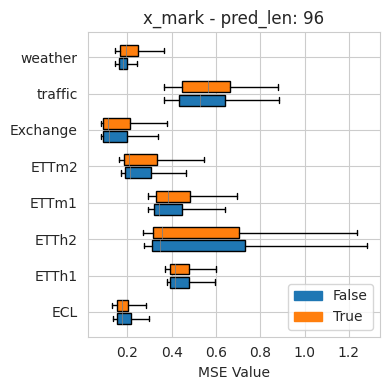

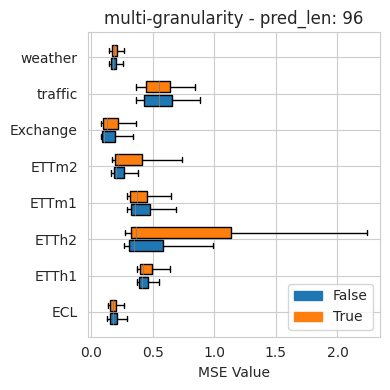

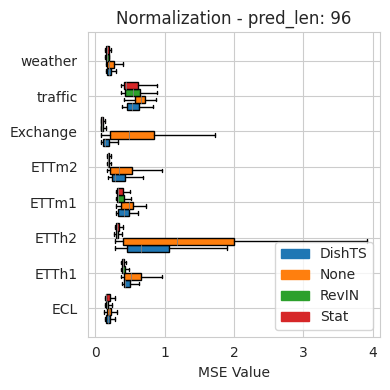

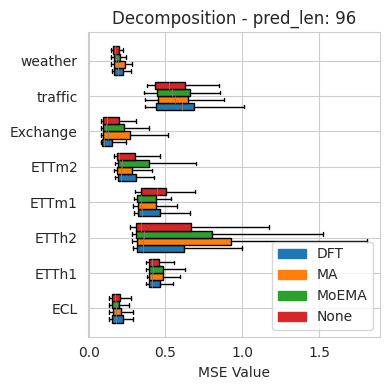

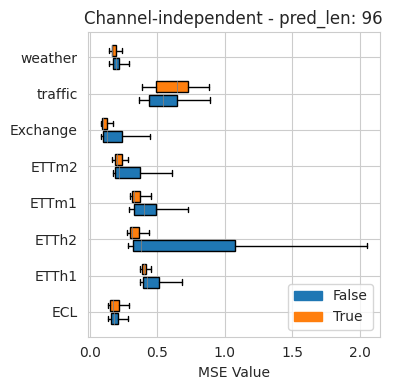

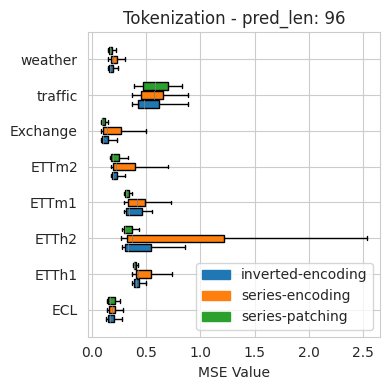

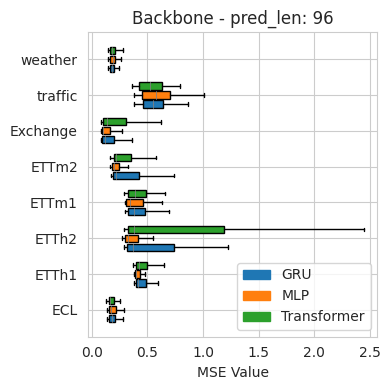

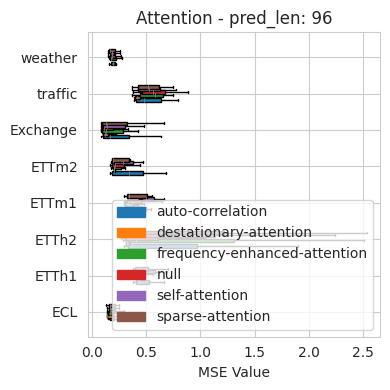

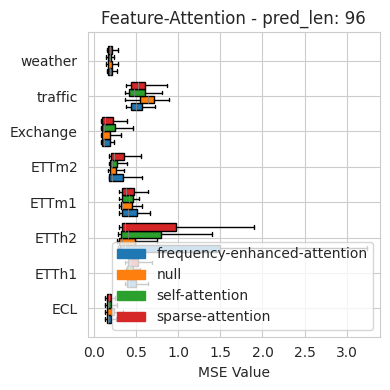

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

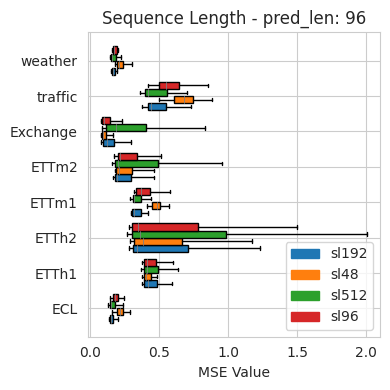

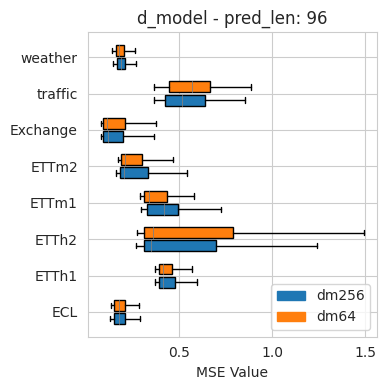

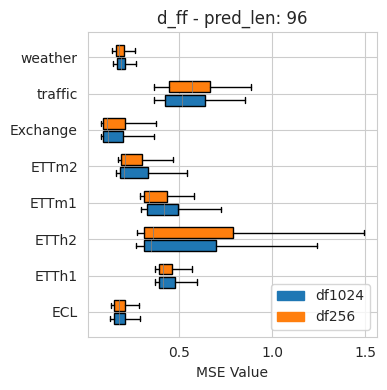

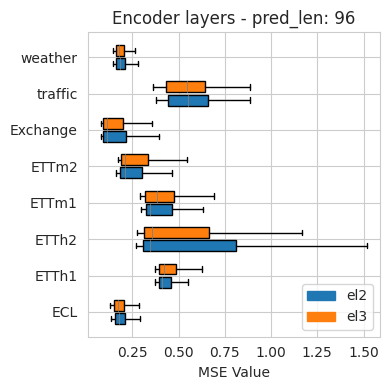

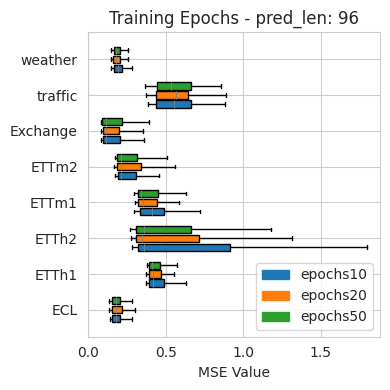

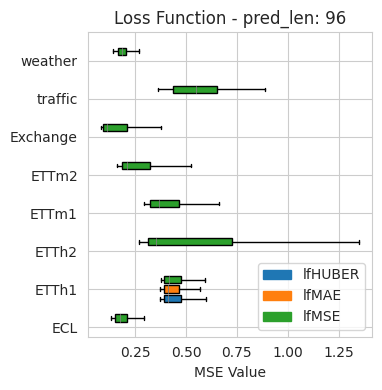

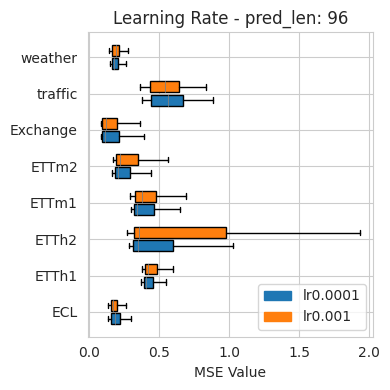

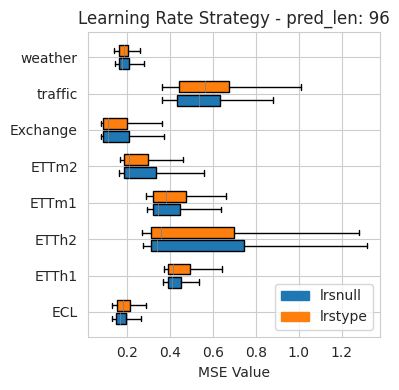

In [4]:
# todo: NaN values?
intros = ['x_mark', 'multi-granularity', 'Normalization', 'Decomposition', 'Channel-independent',
          'Tokenization', 'Backbone', 'Attention', 'Feature-Attention', 'Encoder-only', 'Frozen', 'Dataset',
          'Sequence Length', 'd_model', 'd_ff', 'Encoder layers',
          'Training Epochs', 'Loss Function', 'Learning Rate', 'Learning Rate Strategy']
# ... existing code ...
n=0; 
while True:
    fig = plt.figure(figsize=(4, 4))  # 增大画布高度
    intro = intros[n]
    all_comps = []
    
    # 收集所有可能的comps
    for dataset in datasets:
        pred_len = 96 if dataset not in ['ili', 'fred-md', 'covid-19'] else 24
        comps = set([_.split('_')[n] for _ in result_dict_vis[dataset][pred_len].keys()])
        all_comps.extend(comps)
    unique_comps = sorted(list(set(all_comps)))
    
    if len(unique_comps) <= 1 or 'custom' in unique_comps: 
        n +=1
        continue
    
    # 主绘图参数
    if len(unique_comps) == 3:
        box_height = 0.6 / len(unique_comps)  # 箱体高度（因为vert=False时width控制的是高度）
        offsets = np.linspace(-0.25, 0.25, len(unique_comps))  # 纵轴方向偏移
    elif len(unique_comps) == 4:
        box_height = 0.8 / len(unique_comps)  # 箱体高度（因为vert=False时width控制的是高度）
        offsets = np.linspace(-0.3, 0.3, len(unique_comps))  # 纵轴方向偏移
    else:
        box_height = 0.6 / len(unique_comps)  # 箱体高度（因为vert=False时width控制的是高度）
        offsets = np.linspace(-0.18, 0.18, len(unique_comps))  # 纵轴方向偏移
    
    for i, dataset in enumerate(datasets):
        pred_len = 96 if dataset not in ['ili', 'fred-md', 'covid-19'] else 24
        for j, comp in enumerate(unique_comps):
            # 提取数据
            v = np.array([val for key, val in result_dict_vis[dataset][pred_len].items() 
                        if key.split('_')[n] == comp])
            v = v[~np.isnan(v)]
            v = v[v < 1e+4]
            
            if len(v) <= 1: continue
            
            # 绘制水平箱线图（数值在X轴，数据集在Y轴）
            plt.boxplot(v,
                        vert=False,
                        positions=[i + offsets[j]],
                        widths=box_height,
                        patch_artist=True,
                        boxprops=dict(facecolor=plt.cm.tab10(j)),
                        medianprops=dict(color='grey', linewidth=0.6),  # 新增这行
                        showfliers=False)

    # 设置坐标轴
    plt.yticks(range(len(datasets)), datasets)  # Y轴显示数据集名称
    plt.xlabel('MSE Value')  # X轴标签
    plt.title(f'{intro} - pred_len: {pred_len}')
    
    # 添加图例
    legend_patches = [mpatches.Patch(color=plt.cm.tab10(j), label=comp) 
                    for j, comp in enumerate(unique_comps)]
    plt.legend(handles=legend_patches, loc='lower right')
    plt.tight_layout()
    plt.savefig(f'./notebooks/vis_small_model/{intro}-pred_len_{pred_len}.pdf', bbox_inches='tight', dpi=300)
    
    n +=1
    if n >= len(intros): break